In [1]:
!pip install kikuchipy
!pip install import-ipynb

import import_ipynb
import impAt as at
import re
import torch 
import torch.utils.data as tor_utils
import os
import torch.nn as nn
import torchvision.transforms as transforms
import random
import torchvision.models as torchmodels
import torchvision

import numpy as np

from fastai import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders as fast_dataloaders
from orix.quaternion import Rotation, Symmetry
import kikuchipy as kp
import orix

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
import math

from fastai.losses import BaseLoss
import torch.nn.functional as F
from fastai.vision.all import *
from orix import sampling, plot, io
from orix.vector import Vector3d

importing Jupyter notebook from impAt.ipynb


In [2]:
#List of paths to h5 files containing EBSD pattern data for different types of steel
steelTypes = ["/notebooks/ebsd_data/a.h5", "/notebooks/ebsd_data/f.h5"]#, "steel_chi", "steel_sigma"] 

#Get the number of steel types 
numSteels = len(steelTypes)

#Set the initial electron microscope energy value to 20kV
energy = 20

#Set the scaling factor to reduce the image size for indexing
scaleFactor = 4

#Set the size of the image to be generated
imgSize = int(576 / scaleFactor)

#Initialise an EBSD detector with specific settings
detector = kp.detectors.EBSDDetector(shape = (imgSize, imgSize), sample_tilt = 70, pc = [0.421, 0.7794, 0.5049], convention = "edax")

#Define a batch size for training
batchSize = 32

#Define number of validation examples
num = 5000

#Define the maximum order of symmetry of the steels
maxSize = 96

In [3]:
#Initialise empty tensors to hold images and labels for training and validation datasets
imgs = torch.tensor([])
valImgs = torch.tensor([])
labels = torch.tensor([])
valLabels = torch.tensor([])

#Define a reference tensor for the symmetrical breakdown
reference = torch.tensor([1, 1e-8, 1e-16, 1e-32])

breakdown = at.oneHotSymQuatBreakdown(numSteels)


#Loop through the different types of steels
for i, steel in enumerate(steelTypes):
    
    #Load the steel data and extract its point group
    mp = kp.load(steel, projection = "lambert")
    mpPhase = mp.phase.point_group

    #Generate a set of equally spaced sample rotations in one saymmetrical section
    sampleRot = sampling.get_sample_fundamental(method="cubochoric", resolution = 2.2, point_group = mpPhase)

    #Initialise tensor to hold the labels for the current steel type
    numTrain = sampleRot.shape[0]
    steelLabels = torch.zeros((numTrain, maxSize, numSteels + 4))
    
    #Loop through each sample rotation to populate the labels tensor
    for j in range(numTrain):
        steelLabels[j, :, :] = breakdown.breakdown(sampleRot.data[j, :], i, mpPhase)

    #Generate a set of patterns based off the fundimental rotation sample
    sim = mp.get_patterns(rotations = sampleRot, detector = detector, energy = energy, dtype_out = np.float32, compute = True)

    #Format the simulated data and concatenate with the full training images tensor
    steelImgs = torch.tensor(sim.data).unsqueeze(1).half()
    imgs = torch.cat([imgs, steelImgs], dim=0)
    
    #Generate random grain orientations for validation dataset
    grains = np.deg2rad(np.random.rand(num, 3) * 720 - 360)
    valSampleRot = Rotation.from_euler(grains)

    #Initialise tensor to hold the validation labels for the current steel type
    numVal = valSampleRot.shape[0]
    valSteeLabels = torch.zeros((numVal, 96, numSteels + 4))
    
    #Loop through each sample rotation to populate the validation labels tensor
    for j in range(numVal):
        valSteeLabels[j, :, :] =breakdown.breakdown(valSampleRot.data[j, :], i, mpPhase)

    #Generate a set of patterns based off the random rotation sample    
    valSim = mp.get_patterns(rotations = valSampleRot, detector = detector, energy = energy, dtype_out = np.float32, compute = True)

    #Format the simulated data and concatenate with the full validation images tensor
    steelValmgs = torch.tensor(valSim.data).unsqueeze(1).half()
    valImgs  = torch.cat([valImgs, steelValmgs], dim=0)
    
    
    #Format the labels and concatenate with the full labels tensor
    labels  = torch.cat([labels, steelLabels], dim=0)
    valLabels  = torch.cat([valLabels, valSteeLabels], dim=0)

[########################################] | 100% Completed | 17.55 s
[########################################] | 100% Completed | 2.12 sms
[########################################] | 100% Completed | 16.21 s
[########################################] | 100% Completed | 2.33 sms


In [4]:
#Initialise a transformation to set NaN values to zero
nanFilter = at.setNaNToZero()

#Set parameters for color jittering
brightness = 0.999
contrast = brightness
saturation = brightness
hue = brightness / 2

#Initialise various image augmentation transformations using standard torchvision transforms
sharp = transforms.RandomAdjustSharpness(2, p=0.5)
autocontrast = transforms.RandomAutocontrast(p=0.5)
equalise = transforms.RandomEqualize(p=0.5)
augMix = transforms.AugMix(5, all_ops=False)

jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
valJitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)

erase = transforms.RandomErasing()

#Define lists of transformations for training and validation, using above transforms
trainTransformList = [jitter, sharp, autocontrast, equalise]
valTransformList = [valJitter, sharp, autocontrast, equalise]

#Apply a random chance of activation to the list of transforms
trainTransformList = [at.randomTransform(i, 0.75) for i in trainTransformList]

#Consolidate standard torchvision transforms to a single transform 
trainTransform = at.mixedTransform(trainTransformList)
valTransform = at.mixedTransform(valTransformList)

#Initialise noise and brightness related transformations for training and validation
trainNoise = at.AddNoise(0.1)
valNoise = at.AddNoise(0.1)
 
trainBright = at.Bright(3, size = 144)
valBright = at.Bright(1, size = 144)

trainBrightNoise = at.BrightNoise(0.15)
valBrightNoise = at.BrightNoise(0.1)

#Initialise a random blur transformation
randBlur = at.randomBlur(11)

#Initialise normalisation transformation
Norm = at.Normalise()

#Initialise circular crop transformations
circCrop = at.RandCircularCrop(radius = 50, size = 144)
stdCrop = at.CircularCrop(radius = 72, size = 144)

#Initialise add and scale transformations
add = at.addTo()
scale = at.scaleBy()

#Initialise zoom and stetch transformations
stretcher = at.StretchAndCropTransform(1.3, 1.3, 144)
zoomTmf = at.zoom(1.3)

#Create a list of transformations for training data with random application
tmfs =  [Norm, trainTransform, zoomTmf, randBlur, Norm, trainBright, trainBrightNoise, trainNoise, stretcher, Norm, circCrop, nanFilter]
tmfs = [at.randomTransform(i, 0.75) for i in tmfs]

#Remove random chance from the nanFilter and first normalisation
tmfs[0] = Norm
tmfs[-1] = nanFilter

#Create a list of transformations for validation data
valTmfs =  [Norm, valTransform, Norm, valBright, valBrightNoise, valNoise, Norm, stdCrop, nanFilter]

torch.Size([144, 144])
tensor(1.)
tensor(0.)


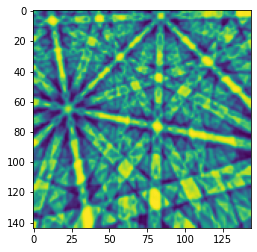

torch.Size([144, 144])
tensor(1.)
tensor(0.)


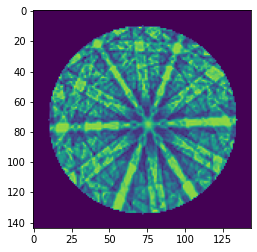

torch.Size([144, 144])
tensor(1.6154)
tensor(-0.5158)


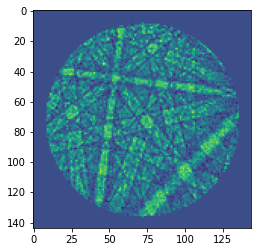

torch.Size([144, 144])
tensor(1.)
tensor(0.)


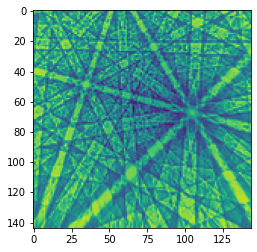

torch.Size([144, 144])
tensor(0.9829)
tensor(0.)


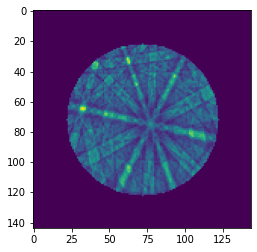

torch.Size([144, 144])
tensor(1.)
tensor(0.)


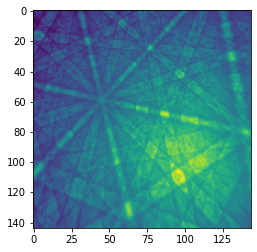

torch.Size([144, 144])
tensor(1.)
tensor(0.)


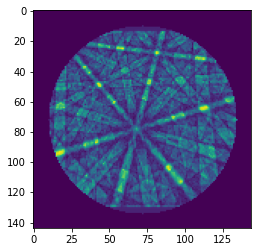

torch.Size([144, 144])
tensor(1.)
tensor(0.)


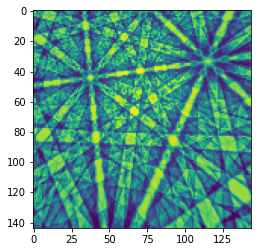

In [5]:
#Create a training and validation dataset using the simulated data
data = at.greyDataset(imgs, labels, tmfs)
valData = at.greyDataset(valImgs, valLabels, valTmfs)


#Create fast ai data loader
fastDls = fast_dataloaders.from_dsets(data, valData, batch_size=batchSize, device = "cuda", shuffle = True, num_workers=12, prefetch_factor=1000)

#Get a single batch of data from the data loader
x = fastDls.one_batch()

#Extract the images from the batch
data = x[0]

#Loop through the first 8 images in the batch
for i in range(8):
    #Extract the image data to CPU
    img = data[i, 0, :, :].cpu()
    
    #Print the shape of the image tensor
    print(img.shape)
    
    #Print the maximum and minimum pixel values in the image tensor
    print(torch.max(img))
    print(torch.min(img))
    
    #Display the image
    plt.imshow(img)
    plt.show()

In [6]:
#Initialise standard pytorch cross entropy loss
ceLoss =  torch.nn.CrossEntropyLoss()

#Define a custom loss funtion that computes the cross-entropy loss between only the steel types one hot encoding
def catLoss(q1, q2):
    return ceLoss(q1[:, -numSteels:], q2[:, 0, -numSteels:]) 

# Defining a mixed loss function that computes the sum of l1 loss between quaternions and the cross-entropy loss between the steel types
def mixedLoss(q1, q2):
    return l1Simple(q1, q2) + catLoss(q1, q2)


#Initialising and renaming loss functions defined above and in impAt
l1Simple = at.quatL1Simple
l1Simple.__name__ = "L1 Simple"

rotDistance = at.quatTrueRotDistance
rotDistance.__name__ = "Rotation Distance"

cat = catLoss
cat.__name__ = "Cross Entropy"

#Defining a list of callbacks to be applied during training
maxGradValue = 1e-2
gradClip = GradientClip(maxGradValue)

cbs = [GradientAccumulation(n_acc = 30), gradClip]

In [7]:
#Set the dropout rate for both convolutional and linear layers
ConvDropOut = 0.5
linDropOut = 0.5

#Define the architecture of the model to be a custom resnet 50 based architecture
arch = at.oneGreyResnet50(4 + numSteels, ConvDropOut, linDropOut)

#Create a fastai learner for training
learn = Learner(fastDls, arch, mixedLoss, metrics = [rotDistance, l1Simple, cat])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#Train using one cycle lr scheduling
learn.fit_one_cycle(10, cbs = cbs)
#learn.save("s9")

#s6 augmix
#s7 no 
#s8 dropout

epoch,train_loss,valid_loss,Rotation Distance,L1 Simple,Cross Entropy,time


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(100, start_epoch = 70, cbs = cbs)
learn.save("S10")